# **IMPORT PACKAGE**

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

# **IMPORT DATA CSV KE DATAFRAME**

In [2]:
df = pd.read_csv('Online Retail Data.csv', header=0)
df.head()

,order_id,product_code,product_name,quantity,order_date,price,customer_id
0,493410,TEST001,This is a test product.,5,2010-01-04 09:24:00,4.50,12346.0
1,C493411,21539,RETRO SPOTS BUTTER DISH,-1,2010-01-04 09:43:00,4.25,14590.0
2,493412,TEST001,This is a test product.,5,2010-01-04 09:53:00,4.50,12346.0
3,493413,21724,PANDA AND BUNNIES STICKER SHEET,1,2010-01-04 09:54:00,0.85,NaN
4,493413,84578,ELEPHANT TOY WITH BLUE T-SHIRT,1,2010-01-04 09:54:00,3.75,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 461773 entries, 0 to 461772
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   order_id      461773 non-null  object 
 1   product_code  461773 non-null  object 
 2   product_name  459055 non-null  object 
 3   quantity      461773 non-null  int64  
 4   order_date    461773 non-null  object 
 5   price         461773 non-null  float64
 6   customer_id   360853 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 24.7+ MB


# **DATA CLEANSING**

In [4]:
df_clean = df.copy()
# membuat kolom date
df_clean['date'] = pd.to_datetime(df_clean['order_date']).dt.date.astype('datetime64[ns]')
# menghapus semua baris tanpa customer_id
df_clean = df_clean[~df_clean['customer_id'].isna()]
# mengkonversi customer_id menjadi string
df_clean['customer_id'] = df_clean['customer_id'].astype(str)
# menghapus semua baris tanpa product_name
df_clean = df_clean[~df_clean['product_name'].isna()]
# membuat semua product_name berhuruf kecil
df_clean['product_name'] = df_clean['product_name'].str.lower()
# menghapus semua baris dengan product_code atau product_name test
df_clean = df_clean[(~df_clean['product_code'].str.lower().str.contains('test')) |
                    (~df_clean['product_name'].str.contains('test '))]
# menghapus baris dengan status cancelled, yaitu yang order_id-nya diawali 'C'
df_clean = df_clean[df_clean['order_id'].str[:1]!='C']
# mengubah nilai quantity yang negatif menjadi positif karena nilai negatif tersebut hanya menandakan order tersebut cancelled
df_clean['quantity'] = df_clean['quantity'].abs()
# menghapus baris dengan price bernilai negatif
df_clean = df_clean[df_clean['price']>0]
# membuat nilai amount, yaitu perkalian antara quantity dan price
df_clean['amount'] = df_clean['quantity'] * df_clean['price']
# mengganti product_name dari product_code yang memiliki beberapa product_name dengan salah satu product_name-nya yang paling sering muncul
most_freq_product_name = df_clean.groupby(['product_code','product_name'], as_index=False).agg(order_cnt=('order_id','nunique')).sort_values(['product_code','order_cnt'], ascending=[True,False])
most_freq_product_name['rank'] = most_freq_product_name.groupby('product_code')['order_cnt'].rank(method='first', ascending=False)
most_freq_product_name = most_freq_product_name[most_freq_product_name['rank']==1].drop(columns=['order_cnt','rank'])
df_clean = df_clean.merge(most_freq_product_name.rename(columns={'product_name':'most_freq_product_name'}), how='left', on='product_code')
df_clean['product_name'] = df_clean['most_freq_product_name']
df_clean = df_clean.drop(columns='most_freq_product_name')
# menghapus outlier
from scipy import stats
df_clean = df_clean[(np.abs(stats.zscore(df_clean[['quantity','amount']]))<3).all(axis=1)]
df_clean = df_clean.reset_index(drop=True)
df_clean.head()

,order_id,product_code,product_name,quantity,order_date,price,customer_id,date,amount
0,493414,21844,red retrospot mug,36,2010-01-04 10:28:00,2.55,14590.0,2010-01-04,91.8
1,493414,21533,retro spot large milk jug,12,2010-01-04 10:28:00,4.25,14590.0,2010-01-04,51.0
2,493414,37508,new england ceramic cake server,2,2010-01-04 10:28:00,2.55,14590.0,2010-01-04,5.1
3,493414,35001G,hand open shape gold,2,2010-01-04 10:28:00,4.25,14590.0,2010-01-04,8.5
4,493414,21527,red retrospot traditional teapot,12,2010-01-04 10:28:00,6.95,14590.0,2010-01-04,83.4


In [5]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350092 entries, 0 to 350091
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   order_id      350092 non-null  object        
 1   product_code  350092 non-null  object        
 2   product_name  350092 non-null  object        
 3   quantity      350092 non-null  int64         
 4   order_date    350092 non-null  object        
 5   price         350092 non-null  float64       
 6   customer_id   350092 non-null  object        
 7   date          350092 non-null  datetime64[ns]
 8   amount        350092 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 24.0+ MB


# EXPLORATORY DATA ANALYSIS

C:\Users\DELL\AppData\Local\Temp\ipykernel_928\308486278.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products.values, y=top_products.index, palette='magma')


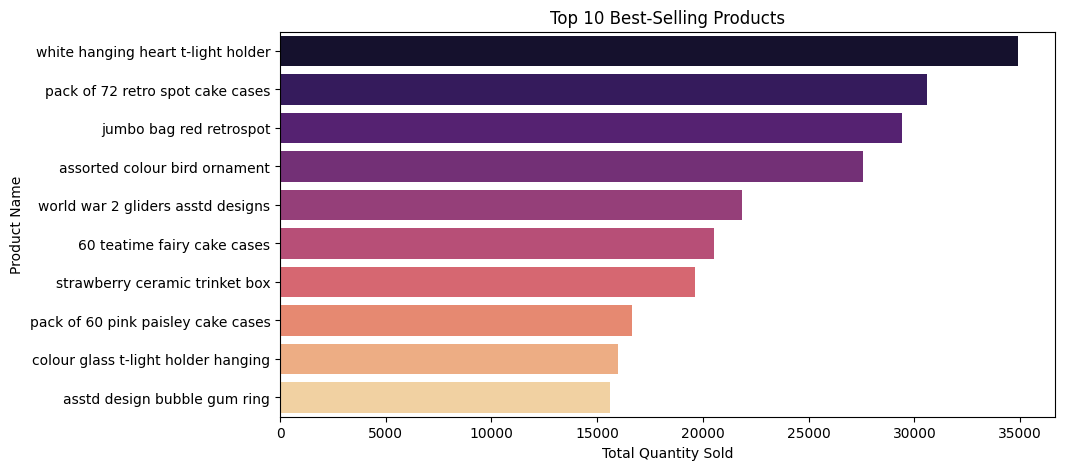

In [6]:
top_products = df_clean.groupby('product_name')['quantity'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_products.values, y=top_products.index, palette='magma')
plt.title('Top 10 Best-Selling Products')
plt.xlabel('Total Quantity Sold')
plt.ylabel('Product Name')
plt.show()

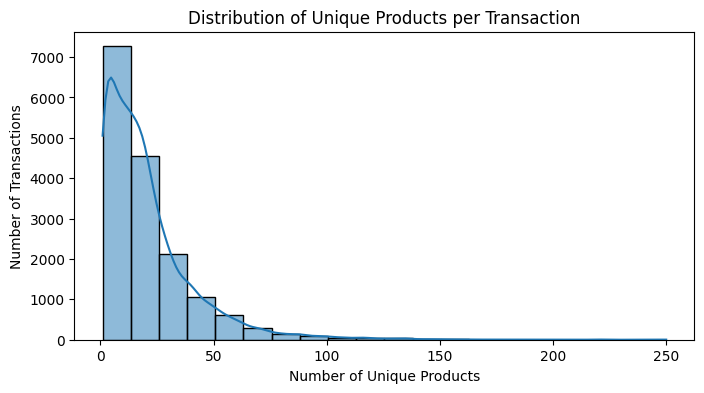

In [7]:
products_per_transaction = df_clean.groupby('order_id')['product_code'].nunique()
plt.figure(figsize=(8,4))
sns.histplot(products_per_transaction, bins=20, kde=True)
plt.title('Distribution of Unique Products per Transaction')
plt.xlabel('Number of Unique Products')
plt.ylabel('Number of Transactions')
plt.show()

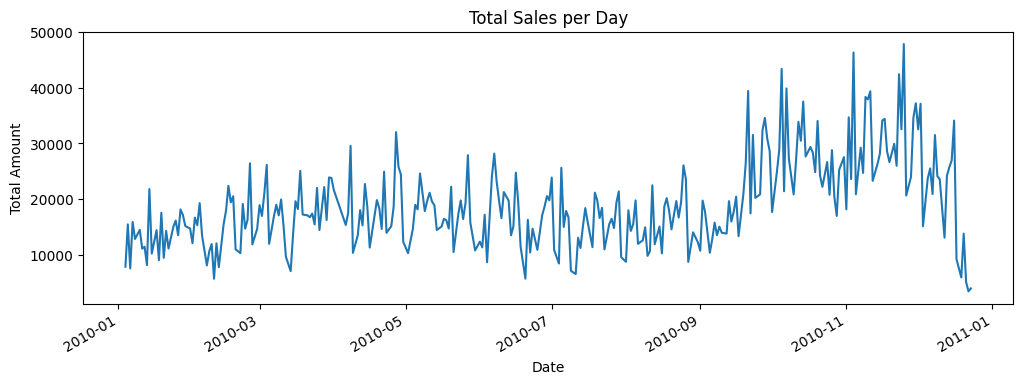

In [8]:
sales_per_day = df_clean.groupby('date')['amount'].sum()
plt.figure(figsize=(12,4))
sales_per_day.plot()
plt.title('Total Sales per Day')
plt.xlabel('Date')
plt.ylabel('Total Amount')
plt.show()

C:\Users\DELL\AppData\Local\Temp\ipykernel_928\2779697944.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_customers.values, y=top_customers.index, palette='magma')


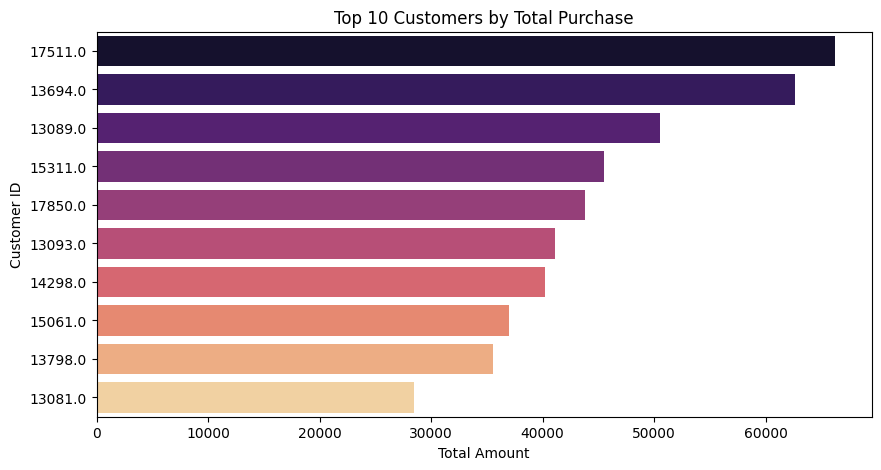

In [9]:
top_customers = df_clean.groupby('customer_id')['amount'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_customers.values, y=top_customers.index, palette='magma')
plt.title('Top 10 Customers by Total Purchase')
plt.xlabel('Total Amount')
plt.ylabel('Customer ID')
plt.show()

# **MENYIAPKAN DATA BASKET**

## Buat DataFrame basket

In [10]:
basket = pd.pivot_table(df_clean, index='order_id', columns='product_name', values='product_code', aggfunc='nunique', fill_value=0)
basket.head()

product_name,10 colour spaceboy pen,12 ass zinc christmas decorations,12 coloured party balloons,12 daisy pegs in wood box,12 egg house painted wood,12 ivory rose peg place settings,12 message cards with envelopes,12 mini toadstool pegs,12 pencil small tube woodland,12 pencils small tube posy,...,zinc heart lattice charger large,zinc heart lattice charger small,zinc heart lattice double planter,zinc heart lattice planter bowl,zinc heart lattice t-light holder,zinc heart lattice tray oval,zinc metal heart decoration,zinc police box lantern,zinc top 2 door wooden shelf,zinc willie winkie candle stick
order_id,,,,,,,,,,,,,,,,,,,,,
493414,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
493427,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
493428,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
493432,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
493433,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
basket.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16272 entries, 493414 to 539988
Columns: 3842 entries, 10 colour spaceboy pen to zinc willie winkie  candle stick
dtypes: int64(3842)
memory usage: 477.1+ MB


## Encode DataFrame basket dengan nilai True untuk semua nilai di atas 0 dan False untuk semua nilai 0

In [12]:
def encode(x):
    if x==0:
        return False
    if x>0:
        return True

basket_encode = basket.applymap(encode)
basket_encode.head()

C:\Users\DELL\AppData\Local\Temp\ipykernel_928\3764393768.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_encode = basket.applymap(encode)


product_name,10 colour spaceboy pen,12 ass zinc christmas decorations,12 coloured party balloons,12 daisy pegs in wood box,12 egg house painted wood,12 ivory rose peg place settings,12 message cards with envelopes,12 mini toadstool pegs,12 pencil small tube woodland,12 pencils small tube posy,...,zinc heart lattice charger large,zinc heart lattice charger small,zinc heart lattice double planter,zinc heart lattice planter bowl,zinc heart lattice t-light holder,zinc heart lattice tray oval,zinc metal heart decoration,zinc police box lantern,zinc top 2 door wooden shelf,zinc willie winkie candle stick
order_id,,,,,,,,,,,,,,,,,,,,,
493414,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
493427,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
493428,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
493432,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
493433,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [13]:
basket_encode.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16272 entries, 493414 to 539988
Columns: 3842 entries, 10 colour spaceboy pen to zinc willie winkie  candle stick
dtypes: bool(3842)
memory usage: 59.7+ MB


## Ambil transaksi dengan banyaknya produk unik lebih dari 1 saja

In [14]:
basket_filter = basket_encode[(basket_encode>0).sum(axis=1)>1]
basket_filter.head()

product_name,10 colour spaceboy pen,12 ass zinc christmas decorations,12 coloured party balloons,12 daisy pegs in wood box,12 egg house painted wood,12 ivory rose peg place settings,12 message cards with envelopes,12 mini toadstool pegs,12 pencil small tube woodland,12 pencils small tube posy,...,zinc heart lattice charger large,zinc heart lattice charger small,zinc heart lattice double planter,zinc heart lattice planter bowl,zinc heart lattice t-light holder,zinc heart lattice tray oval,zinc metal heart decoration,zinc police box lantern,zinc top 2 door wooden shelf,zinc willie winkie candle stick
order_id,,,,,,,,,,,,,,,,,,,,,
493414,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
493427,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
493428,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
493432,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
493433,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [15]:
basket_filter.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15004 entries, 493414 to 539988
Columns: 3842 entries, 10 colour spaceboy pen to zinc willie winkie  candle stick
dtypes: bool(3842)
memory usage: 55.1+ MB


# **MENGAPLIKASIKAN APRIORI ALGORITHM**

## Buat list frequent itemset (kumpulan produk yang sering dibeli)

In [16]:
from mlxtend.frequent_patterns import apriori

frequent_itemset = apriori(basket_filter, min_support=.01, use_colnames=True).sort_values('support', ascending=False).reset_index(drop=True)
frequent_itemset['product_cnt'] = frequent_itemset['itemsets'].apply(lambda x: len(x))
frequent_itemset

,support,itemsets,product_cnt
0,0.177953,(white hanging heart t-light holder),1
1,0.099440,(regency cakestand 3 tier),1
2,0.096841,(jumbo bag red retrospot),1
3,0.079912,(pack of 72 retro spot cake cases),1
4,0.078512,(assorted colour bird ornament),1
...,...,...,...
1189,0.010064,"(jumbo storage bag suki, jumbo bag red retrosp...",3
1190,0.010064,"(key fob , back door , key fob , front door ,...",3
1191,0.010064,"(lunch bag suki design, jumbo storage bag suk...",3
1192,0.010064,"(poppy's playhouse kitchen, poppy's playhouse ...",3


## Hitung nilai support, confidence, dan lift dari setiap pasangan produk yang mungkin

In [17]:
from mlxtend.frequent_patterns import association_rules

product_association = association_rules(frequent_itemset, metric='confidence', min_threshold=.7).sort_values(['support','confidence'], ascending=[False,False]).reset_index(drop=True)
product_association

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(red hanging heart t-light holder),(white hanging heart t-light holder),0.058784,0.177953,0.042455,0.722222,4.058510,1.0,0.031995,2.959371,0.800671,0.218525,0.662090,0.480400
1,(sweetheart ceramic trinket box),(strawberry ceramic trinket box),0.049254,0.074980,0.037457,0.760487,10.142533,1.0,0.033764,3.862089,0.948103,0.431644,0.741073,0.630021
2,(toilet metal sign),(bathroom metal sign),0.026993,0.040589,0.021728,0.804938,19.831353,1.0,0.020632,4.918499,0.975918,0.473837,0.796686,0.670121
3,(red retrospot sugar jam bowl),(red retrospot small milk jug),0.023660,0.037123,0.016796,0.709859,19.121592,1.0,0.015917,3.318652,0.970669,0.381818,0.698673,0.581141
4,(painted metal pears assorted),(assorted colour bird ornament),0.021927,0.078512,0.016596,0.756839,9.639738,1.0,0.014874,3.789618,0.916356,0.197933,0.736121,0.484107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,"(green 3 piece mini dots cutlery set, blue 3 p...",(pink 3 piece mini dots cutlery set),0.011464,0.029992,0.010064,0.877907,29.271370,1.0,0.009720,7.944827,0.977037,0.320594,0.874132,0.606731
82,"(green 3 piece mini dots cutlery set, pink 3 p...",(blue 3 piece mini dots cutlery set),0.011997,0.030525,0.010064,0.838889,27.481853,1.0,0.009698,6.017430,0.975313,0.310062,0.833816,0.584292
83,"(key fob , back door , key fob , front door )","(key fob , shed)",0.012463,0.025060,0.010064,0.807487,32.222153,1.0,0.009752,5.064272,0.981194,0.366505,0.802538,0.604541
84,"(poppy's playhouse kitchen, poppy's playhouse ...",(poppy's playhouse bathroom),0.013730,0.010997,0.010064,0.733010,66.655016,1.0,0.009913,3.704266,0.998709,0.686364,0.730041,0.824081
